In [1]:
import plaidml.keras
plaidml.keras.install_backend()

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import adfuller

from fbprophet import Prophet

import math

# import pyflux as pf

import warnings
warnings.filterwarnings(action='once')

import itertools

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import TimeSeriesSplit

from pandas.plotting import autocorrelation_plot

import re

import sys
import os

from functools import reduce

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Input, LSTM
#from keras.layers import Concatenate
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import model_to_dot, plot_model
from keras.datasets import imdb, reuters
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.models import load_model


from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pickle

from numpy.random import seed

from tensorflow import set_random_seed

/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py:936: DeprecationWarning:

builtin type EagerTensor has no __module__ attribute

/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning:

inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()

/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/keras/backend.py:4712: ResourceWarning:

unclosed file <_io.TextIOWrapper name='/Users/robinleoknauth/.keras/keras.json' mode='r' encoding='UTF-8'>



In [2]:
plt.rcParams['figure.dpi'] = 300

In [3]:
seed(2019)
set_random_seed(2019)

## Importing Data

In [4]:
df_combined = pd.read_pickle('./processed_data/df_combined.pickle')

In [5]:
df_combined.head(2)

,ds,y,vix,gold
0,2017-02-08 00:00:00,1054.03,18.879,2732.0
1,2017-02-08 01:00:00,1060.48,18.915,2693.0


/anaconda3/envs/py36/lib/python3.6/site-packages/seaborn/matrix.py:268: PendingDeprecationWarning:


The label function will be deprecated in a future version. Use Tick.label1 instead.



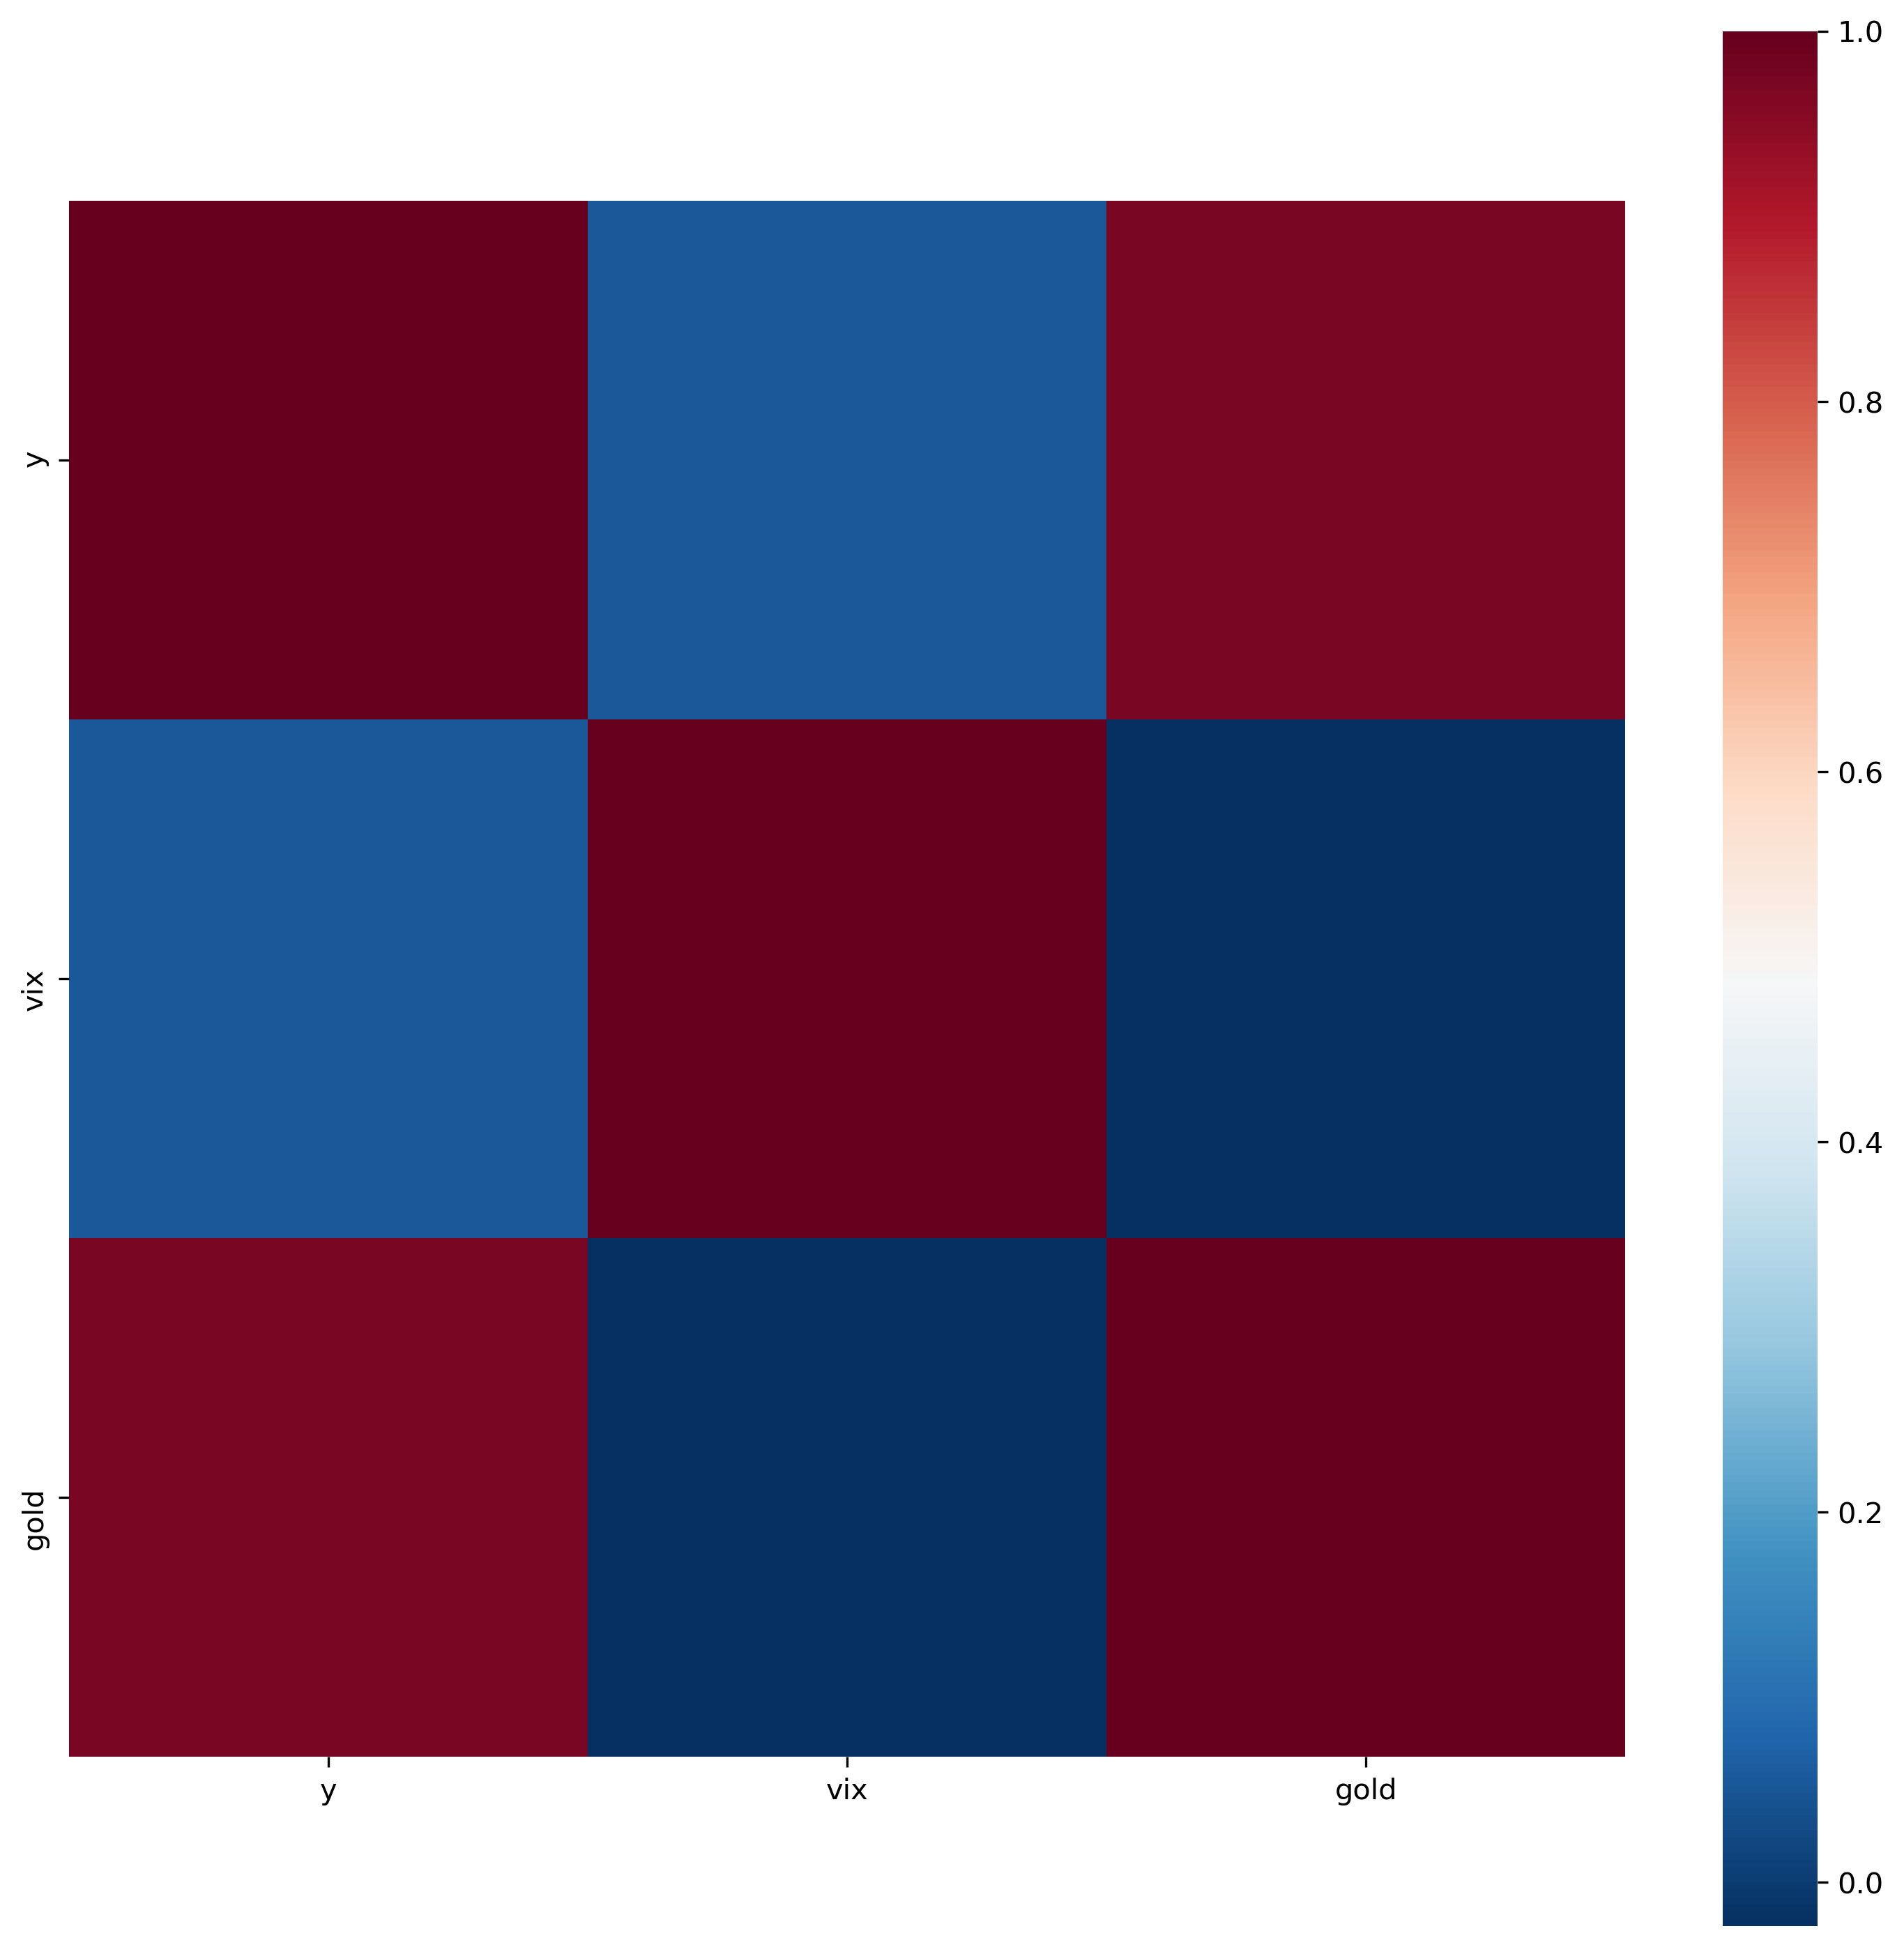

In [6]:
correlations = df_combined.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(correlations, square=True, cmap="RdBu_r");

## Functions

In [7]:
def split_train_test_chronological(df, ratio = 0.9, use_ratio = True, index = 1000):
    
    '''
    Input is a dataframe, and a ratio. Splits dataframe into 2 dataframes chronologically.
    Returns first dataframe up to the index of the length of the input dataframe times the input ratio, 
    and returns second dataframe of remaining elements.
    use_ratio is a flag, wether ratio should be used or indicies instead.
    
    df = input dataframe
    ratio = ratio to be used for splitting
    use_ratio = if True, use ratio, 
    index = index to split input dataframe on
    
    '''
    if use_ratio:
        size = len(df) * ratio
        size_round = round(size)

        df_train = df[0:(size_round)]
        df_test = df[size_round:]
    else:
        df_train = df[0:(index)]
        df_test = df[index:]
    return df_train, df_test

In [8]:
def make_variables(df, lags, look_back, predict_window):
    
    '''
    In order to use keras LSTM, we need to convert the input into a keras-friendly input.
    
    df = input dataframe
    lags = number of lags
    look_back = number of preceding elements to be considered
    predict_window = size of window for predictions
    
    '''
    
    features = lags + 1
    start = look_back
    stop = len(df) - lags - predict_window

    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = df[i - j : i - j + lags + 1, -1]
            lstm_in_X[i - start, index] = np.ravel(X)
            Y = df[i - j + lags + 1, -1]
            lstm_in_Y[i-start, index] = Y
            
    return lstm_in_X, lstm_in_Y, features

In [9]:
def train_lstm(train_X, train_Y, lags, look_back, predict_window, lstm_nodes,
               dense_layers, dropout = 0.1, loss_type = 'hinge', optimizer_type = 'adam',
               number_epochs = 300, batch_size = 24, ):
    
    
    model = Sequential()
    model.add(LSTM(lstm_nodes, input_shape=(look_back+1, features)))
    model.add(Dropout(dropout))
    for nodes in dense_layers:
        model.add(Dense(nodes))
        model.add(Dropout(dropout))
    model.add(Dense(look_back + 1))
    model.compile(loss=loss_type, optimizer= optimizer_type)
    model.fit(train_X, train_Y, epochs=number_epochs, batch_size = batch_size, verbose = 1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [61]:
def make_rolling_window(model, train_x, train_y, test_x, test_y, batch_size = 218, epochs = 2):
    predictions_test = []
    actuals_test = []
    yhats = []
    ys = []
    
    dimension = train_x.shape[2]
    
    for i in range(0, len(test_y) - 1):
        model.fit(train_x, train_y, 
                    epochs= epochs, 
                    batch_size = batch_size, 
                    validation_data=(test_x[i].reshape(1,1,dimension), (test_y[i].reshape(1 ,))),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)
        pred_Y_test = model.predict(test_x[i].reshape(1,1,dimension))
        train_x = np.concatenate((train_x, (test_x[i].reshape(1 , 1 , dimension))))

        train_y = np.concatenate((train_y, (test_y[i].reshape(1 ,))))
        predict_test = pred_Y_test[-1,-1]
        actual_test = train_y[-1]
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        yhats.append(pred_Y_test)
        ys.append(test_y[i])
        
    return predictions_test, actuals_test, yhats, ys

In [11]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    
    
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

## Train, Val, Test split

In [12]:
df_train, df_test = split_train_test_chronological(df_combined, ratio = .99)

In [13]:
df_train, df_val = split_train_test_chronological(df_combined, ratio = .95)

## Getting data in shape for LSTM Modeling

In [77]:
# load dataset
values = df_combined.drop('ds', axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
reframed.head()
# reframed_2 = series_to_supervised(values, 7, 1)
# reframed_2.head()

,var1(t-7),var2(t-7),var3(t-7),var1(t-6),var2(t-6),var3(t-6),var1(t-5),var2(t-5),var3(t-5),var1(t-4),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
7,-1.846505,-1.736062,-1.485503,-1.844531,-1.731960,-1.498043,-1.843778,-1.738227,-1.491895,-1.842896,...,-1.482255,-1.842746,-1.736176,-1.484451,-1.842823,-1.73515,-1.485464,-1.842762,-1.73515,-1.485515
8,-1.844531,-1.731960,-1.498043,-1.843778,-1.738227,-1.491895,-1.842896,-1.748482,-1.481647,-1.842183,...,-1.484451,-1.842823,-1.735150,-1.485464,-1.842762,-1.73515,-1.485515,-1.852667,-1.73515,-1.492509
9,-1.843778,-1.738227,-1.491895,-1.842896,-1.748482,-1.481647,-1.842183,-1.748482,-1.482255,-1.842746,...,-1.485464,-1.842762,-1.735150,-1.485515,-1.852667,-1.73515,-1.492509,-1.853194,-1.73515,-1.489583
10,-1.842896,-1.748482,-1.481647,-1.842183,-1.748482,-1.482255,-1.842746,-1.736176,-1.484451,-1.842823,...,-1.485515,-1.852667,-1.735150,-1.492509,-1.853194,-1.73515,-1.489583,-1.851479,-1.73515,-1.485184
11,-1.842183,-1.748482,-1.482255,-1.842746,-1.736176,-1.484451,-1.842823,-1.735150,-1.485464,-1.842762,...,-1.492509,-1.853194,-1.735150,-1.489583,-1.851479,-1.73515,-1.485184,-1.849177,-1.73515,-1.489368


In [358]:
# drop columns we don't want to predict
y = reframed.iloc[:,-12].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]


test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [56]:
X.shape

(12596, 218)

In [303]:
y

array([-1.8421831 , -1.8427463 , -1.8428228 , ...,  0.4367851 ,
        0.43582702,  0.44757515], dtype=float32)

### Unscaled data for experiments

In [276]:
# # drop columns we don't want to predict
# y = reframed_2.iloc[:,-12].values
# X = reframed_2.drop('var1(t)', axis =1).values
# # split into train and test sets

# n_train_hours = 12000
# n_test_hours = 320
# train_X = X[:n_train_hours,:]
# train_y = y[:n_train_hours]

# val_X= X[n_train_hours:-n_test_hours,]
# val_y= y[n_train_hours:-n_test_hours]

# test_X = X[-n_test_hours:,:]
# test_y = y[-n_test_hours:]



# # reshape input to be 3D [samples, timesteps, features]
# train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
# val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
# test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
# print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 23) (12000,) (341, 1, 23) (341,) (320, 1, 23) (320,)


In [277]:
y                          

array([1068.15, 1066.31, 1066.06, ..., 8513.3 , 8510.17, 8548.55],
      dtype=float32)

# Modeling

In [323]:
LSTM_model_4 = Sequential()
LSTM_model_4.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.20,recurrent_dropout=0.20))
# LSTM_model_4.add(LSTM(128))
LSTM_model_4.add(Dense(32))
LSTM_model_4.add(Dense(32))
# LSTM_model_4.add(LSTM(16, activation='relu'))
LSTM_model_4.add(Dense(1))
LSTM_model_4.compile(optimizer='adam', loss='mse')



In [324]:
history_4 = LSTM_model_4.fit(train_X, train_y, 
                    epochs= 100, 
                    batch_size = 32, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 341 samples
Epoch 1/100
 - 12s - loss: 0.1489 - val_loss: 0.0025
Epoch 2/100
 - 7s - loss: 0.0357 - val_loss: 0.0039
Epoch 3/100
 - 7s - loss: 0.0301 - val_loss: 0.0108
Epoch 4/100
 - 7s - loss: 0.0271 - val_loss: 0.0034
Epoch 5/100
 - 7s - loss: 0.0263 - val_loss: 0.0018
Epoch 6/100
 - 7s - loss: 0.0273 - val_loss: 0.0023
Epoch 7/100
 - 7s - loss: 0.0246 - val_loss: 0.0023
Epoch 8/100
 - 7s - loss: 0.0223 - val_loss: 0.0015
Epoch 9/100
 - 7s - loss: 0.0248 - val_loss: 0.0023
Epoch 10/100
 - 7s - loss: 0.0226 - val_loss: 0.0023
Epoch 11/100
 - 7s - loss: 0.0194 - val_loss: 0.0017
Epoch 12/100
 - 7s - loss: 0.0199 - val_loss: 0.0023
Epoch 13/100
 - 7s - loss: 0.0192 - val_loss: 0.0033
Epoch 14/100
 - 7s - loss: 0.0186 - val_loss: 0.0034
Epoch 15/100
 - 7s - loss: 0.0175 - val_loss: 0.0047
Epoch 16/100
 - 7s - loss: 0.0163 - val_loss: 0.0066
Epoch 17/100
 - 6s - loss: 0.0157 - val_loss: 0.0046
Epoch 18/100
 - 6s - loss: 0.0146 - val_loss: 0.0033
Epoch 

In [325]:
res_4 = make_rolling_window(LSTM_model_4, train_X, train_y, val_X, val_y)

Train on 12000 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 0.0038 - val_loss: 0.0207
Epoch 2/2
 - 7s - loss: 0.0033 - val_loss: 0.0207
Train on 12001 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 0.0031 - val_loss: 0.0203
Epoch 2/2
 - 7s - loss: 0.0032 - val_loss: 0.0291
Train on 12002 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 0.0027 - val_loss: 0.0172
Epoch 2/2
 - 7s - loss: 0.0028 - val_loss: 0.0189
Train on 12003 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 0.0029 - val_loss: 0.0158
Epoch 2/2
 - 7s - loss: 0.0027 - val_loss: 0.0230
Train on 12004 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 0.0029 - val_loss: 0.0151
Epoch 2/2
 - 7s - loss: 0.0031 - val_loss: 0.0125
Train on 12005 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 0.0027 - val_loss: 0.0078
Epoch 2/2
 - 6s - loss: 0.0026 - val_loss: 0.0090
Train on 12006 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 0.0028 - val_loss: 0.0173
Epoch 2/2
 - 6s - loss: 0.0

Train on 12056 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0015 - val_loss: 0.0257
Epoch 2/2
 - 7s - loss: 0.0015 - val_loss: 0.0238
Train on 12057 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0013 - val_loss: 0.0215
Epoch 2/2
 - 7s - loss: 0.0015 - val_loss: 0.0207
Train on 12058 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0011 - val_loss: 0.0212
Epoch 2/2
 - 7s - loss: 0.0012 - val_loss: 0.0202
Train on 12059 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0016 - val_loss: 0.0252
Epoch 2/2
 - 7s - loss: 0.0014 - val_loss: 0.0240
Train on 12060 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0014 - val_loss: 0.0272
Epoch 2/2
 - 7s - loss: 0.0013 - val_loss: 0.0291
Train on 12061 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0011 - val_loss: 0.0242
Epoch 2/2
 - 7s - loss: 0.0012 - val_loss: 0.0249
Train on 12062 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0015 - val_loss: 0.0230
Epoch 2/2
 - 7s - loss: 0.00

Train on 12111 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 0.0010 - val_loss: 0.0412
Epoch 2/2
 - 8s - loss: 9.7810e-04 - val_loss: 0.0436
Train on 12112 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.0011 - val_loss: 0.0277
Epoch 2/2
 - 8s - loss: 8.8790e-04 - val_loss: 0.0271
Train on 12113 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.3300e-04 - val_loss: 0.0165
Epoch 2/2
 - 8s - loss: 7.4576e-04 - val_loss: 0.0206
Train on 12114 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 0.0011 - val_loss: 0.0218
Epoch 2/2
 - 8s - loss: 9.0547e-04 - val_loss: 0.0213
Train on 12115 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.9313e-04 - val_loss: 0.0269
Epoch 2/2
 - 8s - loss: 7.2442e-04 - val_loss: 0.0282
Train on 12116 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 6.7615e-04 - val_loss: 0.0329
Epoch 2/2
 - 7s - loss: 7.7732e-04 - val_loss: 0.0366
Train on 12117 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 8.9701e-04 - val_l

Epoch 2/2
 - 9s - loss: 6.4763e-04 - val_loss: 0.0378
Train on 12165 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.8263e-04 - val_loss: 0.0389
Epoch 2/2
 - 8s - loss: 0.0010 - val_loss: 0.0360
Train on 12166 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 6.9754e-04 - val_loss: 0.0406
Epoch 2/2
 - 8s - loss: 6.9954e-04 - val_loss: 0.0368
Train on 12167 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.3595e-04 - val_loss: 0.0415
Epoch 2/2
 - 8s - loss: 6.6572e-04 - val_loss: 0.0420
Train on 12168 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 8.9713e-04 - val_loss: 0.0419
Epoch 2/2
 - 8s - loss: 6.1365e-04 - val_loss: 0.0408
Train on 12169 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 6.9388e-04 - val_loss: 0.0447
Epoch 2/2
 - 8s - loss: 7.2523e-04 - val_loss: 0.0456
Train on 12170 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.6974e-04 - val_loss: 0.0461
Epoch 2/2
 - 7s - loss: 7.0964e-04 - val_loss: 0.0444
Train on 12171 samples, va

Train on 12218 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 7.6246e-04 - val_loss: 0.0479
Epoch 2/2
 - 7s - loss: 6.0827e-04 - val_loss: 0.0438
Train on 12219 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 5.7693e-04 - val_loss: 0.0424
Epoch 2/2
 - 7s - loss: 8.2600e-04 - val_loss: 0.0426
Train on 12220 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 7.0067e-04 - val_loss: 0.0471
Epoch 2/2
 - 7s - loss: 5.9895e-04 - val_loss: 0.0432
Train on 12221 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 6.9142e-04 - val_loss: 0.0504
Epoch 2/2
 - 7s - loss: 8.0430e-04 - val_loss: 0.0531
Train on 12222 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 8.5396e-04 - val_loss: 0.0535
Epoch 2/2
 - 7s - loss: 6.5396e-04 - val_loss: 0.0516
Train on 12223 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 5.8398e-04 - val_loss: 0.0390
Epoch 2/2
 - 7s - loss: 7.0694e-04 - val_loss: 0.0388
Train on 12224 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 6.8136

 - 8s - loss: 5.8869e-04 - val_loss: 0.0362
Epoch 2/2
 - 8s - loss: 6.7599e-04 - val_loss: 0.0403
Train on 12272 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 7.3589e-04 - val_loss: 0.0410
Epoch 2/2
 - 8s - loss: 6.9106e-04 - val_loss: 0.0363
Train on 12273 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.0213e-04 - val_loss: 0.0401
Epoch 2/2
 - 7s - loss: 6.0741e-04 - val_loss: 0.0414
Train on 12274 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.2099e-04 - val_loss: 0.0405
Epoch 2/2
 - 8s - loss: 7.7719e-04 - val_loss: 0.0425
Train on 12275 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.0598e-04 - val_loss: 0.0491
Epoch 2/2
 - 8s - loss: 6.7355e-04 - val_loss: 0.0427
Train on 12276 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.5808e-04 - val_loss: 0.0432
Epoch 2/2
 - 8s - loss: 0.0011 - val_loss: 0.0464
Train on 12277 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.5889e-04 - val_loss: 0.0352
Epoch 2/2
 - 8s - loss: 7.4190e-04 -

Epoch 2/2
 - 9s - loss: 6.7254e-04 - val_loss: 0.0360
Train on 12325 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 7.7215e-04 - val_loss: 0.0439
Epoch 2/2
 - 9s - loss: 7.0857e-04 - val_loss: 0.0421
Train on 12326 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.6732e-04 - val_loss: 0.0357
Epoch 2/2
 - 8s - loss: 6.8143e-04 - val_loss: 0.0387
Train on 12327 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.7904e-04 - val_loss: 0.0264
Epoch 2/2
 - 8s - loss: 5.7037e-04 - val_loss: 0.0272
Train on 12328 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.7326e-04 - val_loss: 0.0502
Epoch 2/2
 - 8s - loss: 4.4947e-04 - val_loss: 0.0539
Train on 12329 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.9138e-04 - val_loss: 0.0554
Epoch 2/2
 - 8s - loss: 4.7401e-04 - val_loss: 0.0589
Train on 12330 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.5122e-04 - val_loss: 0.0455
Epoch 2/2
 - 8s - loss: 5.8795e-04 - val_loss: 0.0460
Train on 12331 samples

In [395]:
# keras.models.save_model(
#     LSTM_model_4,
#     './saved_models/LSTM_model_4_fit.hdf5',
#     overwrite=True,
#     include_optimizer=True
# )

inverse transform the predictions into the units we care about. 


In [65]:
scaler_2 = StandardScaler()
scaled = scaler_2.fit_transform(np.array(df_train.y).reshape(-1,1))

In [466]:
predicts = scaler_2.inverse_transform(np.array(res_4[0]))

In [467]:
actuals = scaler_2.inverse_transform(np.array(res_4[1]))

In [489]:
rmse = math.sqrt(mean_squared_error(predicts, actuals))
print('VAL RMSE: %.3f' % rmse)

VAL RMSE: 596.715


In [387]:
# LSTM_model_copy = keras.models.clone_model(LSTM_model_4)
# LSTM_model_copy.set_weights(LSTM_model_4.get_weights())

In [398]:
LSTM_model_copy = load_model('./saved_models/LSTM_model_4_fit.hdf5')

In [32]:
train_and_val_X = np.concatenate((train_X, val_X), axis = 0)

In [33]:
train_and_val_y = np.concatenate((train_y, val_y), axis = 0)

(12341,)

In [399]:
res_5 = make_rolling_window(LSTM_model_copy, train_and_val_X, train_and_val_y, test_X, test_y)

Train on 12341 samples, validate on 1 samples
Epoch 1/2
 - 11s - loss: 5.8148e-04 - val_loss: 0.0461
Epoch 2/2
 - 8s - loss: 6.9582e-04 - val_loss: 0.0485
Train on 12342 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 7.6007e-04 - val_loss: 0.0439
Epoch 2/2
 - 8s - loss: 8.1701e-04 - val_loss: 0.0421
Train on 12343 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.4487e-04 - val_loss: 0.0439
Epoch 2/2
 - 8s - loss: 8.4975e-04 - val_loss: 0.0398
Train on 12344 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.8533e-04 - val_loss: 0.0514
Epoch 2/2
 - 8s - loss: 5.4684e-04 - val_loss: 0.0519
Train on 12345 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.6137e-04 - val_loss: 0.0552
Epoch 2/2
 - 8s - loss: 6.5816e-04 - val_loss: 0.0577
Train on 12346 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.2000e-04 - val_loss: 0.0519
Epoch 2/2
 - 8s - loss: 6.3381e-04 - val_loss: 0.0519
Train on 12347 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.321

 - 9s - loss: 8.1042e-04 - val_loss: 0.0404
Epoch 2/2
 - 8s - loss: 5.8288e-04 - val_loss: 0.0428
Train on 12395 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.8810e-04 - val_loss: 0.0437
Epoch 2/2
 - 8s - loss: 5.9308e-04 - val_loss: 0.0437
Train on 12396 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.0254e-04 - val_loss: 0.0471
Epoch 2/2
 - 8s - loss: 5.7872e-04 - val_loss: 0.0471
Train on 12397 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.0220e-04 - val_loss: 0.0501
Epoch 2/2
 - 8s - loss: 4.4120e-04 - val_loss: 0.0516
Train on 12398 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.2328e-04 - val_loss: 0.0476
Epoch 2/2
 - 8s - loss: 5.7248e-04 - val_loss: 0.0498
Train on 12399 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 6.1911e-04 - val_loss: 0.0458
Epoch 2/2
 - 8s - loss: 5.6389e-04 - val_loss: 0.0474
Train on 12400 samples, validate on 1 samples
Epoch 1/2
 - 8s - loss: 5.0239e-04 - val_loss: 0.0460
Epoch 2/2
 - 9s - loss: 4.8912e-

 - 10s - loss: 4.4993e-04 - val_loss: 0.0435
Epoch 2/2
 - 9s - loss: 4.8267e-04 - val_loss: 0.0442
Train on 12448 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.2677e-04 - val_loss: 0.0440
Epoch 2/2
 - 10s - loss: 5.3236e-04 - val_loss: 0.0467
Train on 12449 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.3158e-04 - val_loss: 0.0516
Epoch 2/2
 - 10s - loss: 7.9487e-04 - val_loss: 0.0493
Train on 12450 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.9852e-04 - val_loss: 0.0497
Epoch 2/2
 - 10s - loss: 6.6936e-04 - val_loss: 0.0530
Train on 12451 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 8.1387e-04 - val_loss: 0.0500
Epoch 2/2
 - 10s - loss: 5.2831e-04 - val_loss: 0.0465
Train on 12452 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 6.1476e-04 - val_loss: 0.0461
Epoch 2/2
 - 9s - loss: 6.1005e-04 - val_loss: 0.0438
Train on 12453 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 6.0335e-04 - val_loss: 0.0439
Epoch 2/2
 - 10s - los

Train on 12500 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.8003e-04 - val_loss: 0.0417
Epoch 2/2
 - 10s - loss: 4.4947e-04 - val_loss: 0.0407
Train on 12501 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 6.0064e-04 - val_loss: 0.0438
Epoch 2/2
 - 10s - loss: 5.1509e-04 - val_loss: 0.0432
Train on 12502 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.3845e-04 - val_loss: 0.0424
Epoch 2/2
 - 10s - loss: 4.8686e-04 - val_loss: 0.0415
Train on 12503 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.6699e-04 - val_loss: 0.0416
Epoch 2/2
 - 10s - loss: 5.1915e-04 - val_loss: 0.0425
Train on 12504 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.2416e-04 - val_loss: 0.0423
Epoch 2/2
 - 10s - loss: 4.4292e-04 - val_loss: 0.0449
Train on 12505 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 6.0644e-04 - val_loss: 0.0397
Epoch 2/2
 - 10s - loss: 5.1473e-04 - val_loss: 0.0373
Train on 12506 samples, validate on 1 samples
Epoch 1/2
 - 9s - 

Epoch 2/2
 - 10s - loss: 5.6129e-04 - val_loss: 0.0479
Train on 12553 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.5645e-04 - val_loss: 0.0492
Epoch 2/2
 - 10s - loss: 5.1804e-04 - val_loss: 0.0489
Train on 12554 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 6.5387e-04 - val_loss: 0.0469
Epoch 2/2
 - 10s - loss: 4.5990e-04 - val_loss: 0.0453
Train on 12555 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.7109e-04 - val_loss: 0.0461
Epoch 2/2
 - 10s - loss: 6.8560e-04 - val_loss: 0.0431
Train on 12556 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.2685e-04 - val_loss: 0.0462
Epoch 2/2
 - 10s - loss: 5.1109e-04 - val_loss: 0.0471
Train on 12557 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.8202e-04 - val_loss: 0.0428
Epoch 2/2
 - 10s - loss: 6.0596e-04 - val_loss: 0.0472
Train on 12558 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.7355e-04 - val_loss: 0.0456
Epoch 2/2
 - 10s - loss: 4.1677e-04 - val_loss: 0.0481
Train on 

 - 10s - loss: 4.4921e-04 - val_loss: 0.0268
Epoch 2/2
 - 10s - loss: 3.9956e-04 - val_loss: 0.0269
Train on 12606 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.0157e-04 - val_loss: 0.0270
Epoch 2/2
 - 10s - loss: 4.7071e-04 - val_loss: 0.0284
Train on 12607 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 3.9828e-04 - val_loss: 0.0291
Epoch 2/2
 - 10s - loss: 6.5637e-04 - val_loss: 0.0285
Train on 12608 samples, validate on 1 samples
Epoch 1/2
 - 9s - loss: 4.0669e-04 - val_loss: 0.0280
Epoch 2/2
 - 10s - loss: 5.2375e-04 - val_loss: 0.0275
Train on 12609 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.5116e-04 - val_loss: 0.0307
Epoch 2/2
 - 10s - loss: 5.4348e-04 - val_loss: 0.0304
Train on 12610 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 5.4511e-04 - val_loss: 0.0324
Epoch 2/2
 - 10s - loss: 4.7117e-04 - val_loss: 0.0304
Train on 12611 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.4065e-04 - val_loss: 0.0297
Epoch 2/2
 - 10s - l

Train on 12658 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 3.5090e-04 - val_loss: 0.0051
Epoch 2/2
 - 10s - loss: 4.7269e-04 - val_loss: 0.0043
Train on 12659 samples, validate on 1 samples
Epoch 1/2
 - 10s - loss: 4.5841e-04 - val_loss: 0.0028
Epoch 2/2
 - 10s - loss: 5.2126e-04 - val_loss: 0.0025


In [488]:
predicts_roll = scaler_2.inverse_transform(np.array(res_5[0]))
actuals_roll = scaler_2.inverse_transform(np.array(res_5[1]))
rmse = math.sqrt(mean_squared_error(predicts_roll, actuals_roll))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 639.572


In [403]:
keras.models.save_model(
    LSTM_model_copy,
    './saved_models/LSTM_model_4_fit_after_preds.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [470]:
len(res_5[1])

319

In [67]:
def predicts_signs(preds_s, actuals_s):
    result = []
    for i in range(1, len(preds_s) + 1):
        if ((preds_s[i] > 0) and (actuals_s[i] > 0)):
            result.append(1)
        elif ((preds_s[i] < 0) and (actuals_s[i] < 0)):
            result.append(1)
        else:
            result.append(0)
    return result

In [484]:
sings_preds_rolling = pd.Series(predicts_roll).diff()[1:]

In [483]:
sings_actuals_rolling = pd.Series(actuals_roll).diff()[1:]

In [485]:
correct_predictions_signs_roll = predicts_signs(sings_preds_rolling, sings_actuals_rolling)

In [486]:
sum(correct_predictions_signs_roll) / len(correct_predictions_signs_roll)

0.5440251572327044

Text(0, 0.5, 'Bitcoin price in dollars')

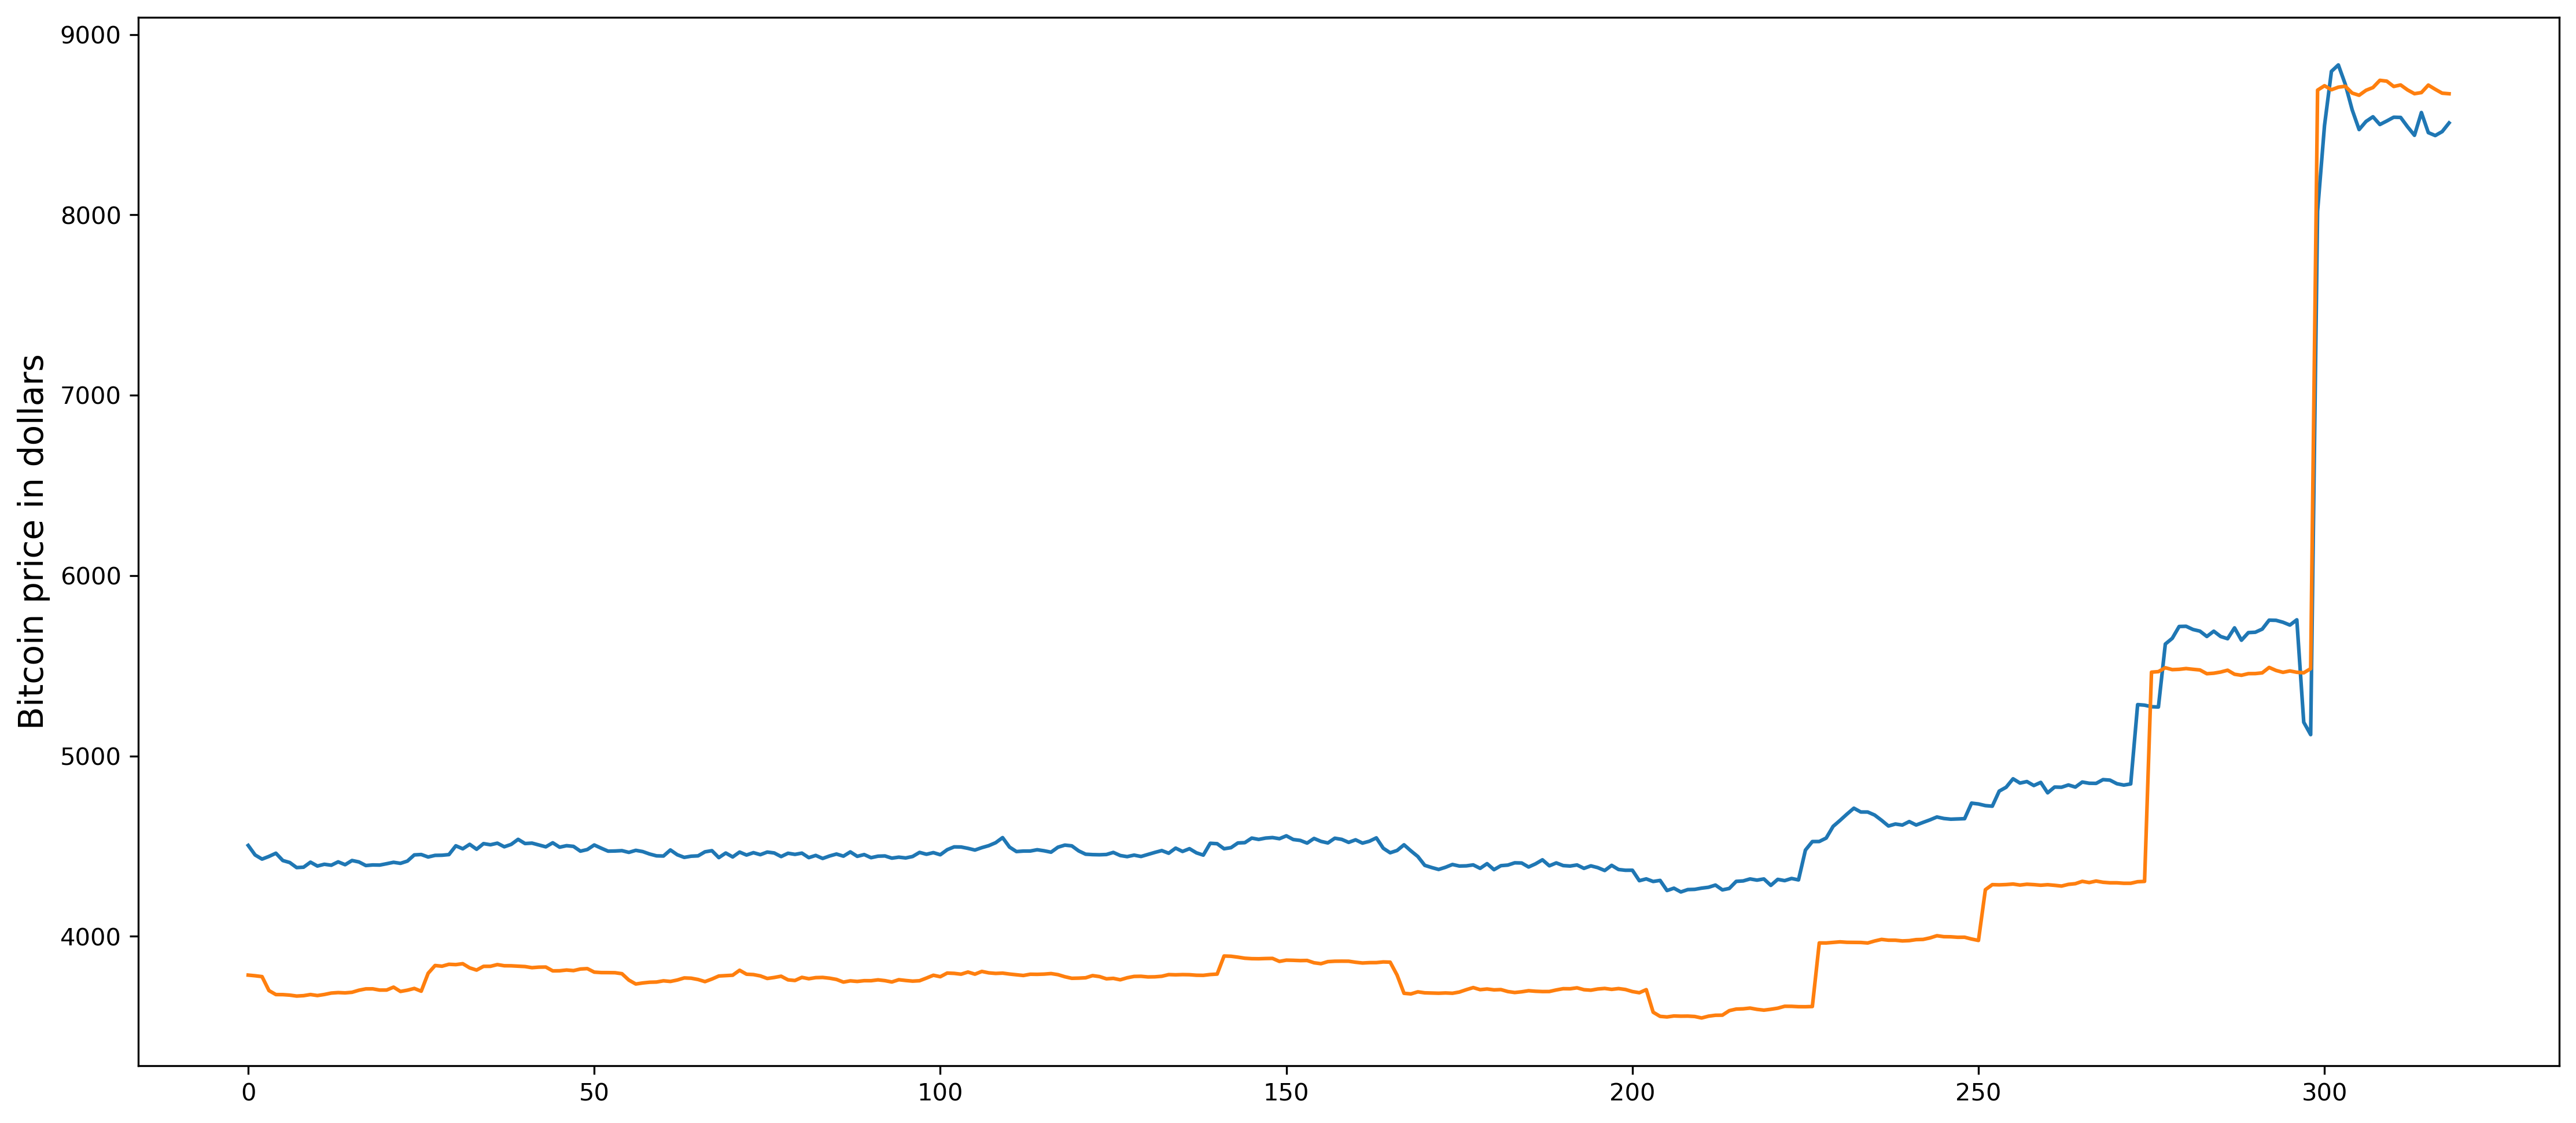

In [504]:
plt.figure(figsize=(18,8))
sns.lineplot(data = predicts_roll)
sns.lineplot(data = actuals_roll)
plt.ylabel('Bitcoin price in dollars', size = 14)

In [507]:
plt.savefig('./saved_plots/LSTM_predictions.png')

<Figure size 1800x1200 with 0 Axes>

## Comparison of LSTM with and without exogenous variables

In [16]:
# load dataset
values = df_combined.drop(['ds', 'vix', 'gold'], axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)

reframed_2 = series_to_supervised(values, 7, 1)
reframed_2.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,1054.030029,1060.479980,1062.939941,1065.819946,1068.150024,1066.310059,1066.060059,1066.260010
8,1060.479980,1062.939941,1065.819946,1068.150024,1066.310059,1066.060059,1066.260010,1033.900024
9,1062.939941,1065.819946,1068.150024,1066.310059,1066.060059,1066.260010,1033.900024,1032.180054
10,1065.819946,1068.150024,1066.310059,1066.060059,1066.260010,1033.900024,1032.180054,1037.780029
11,1068.150024,1066.310059,1066.060059,1066.260010,1033.900024,1032.180054,1037.780029,1045.300049


In [19]:
# drop columns we don't want to predict
y = reframed.iloc[:,-7].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]


test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 7) (12000,) (341, 1, 7) (341,) (320, 1, 7) (320,)


In [20]:
y

array([-1.8445308 , -1.8437779 , -1.8428963 , ...,  0.43780443,
        0.45053843,  0.4433848 ], dtype=float32)

## Model

In [27]:
# load dataset
values = df_combined.drop('ds', axis = 1).values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
# scaler = MinMaxScaler()
scaler = StandardScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 72, 1)
reframed.head()
# reframed_2 = series_to_supervised(values, 7, 1)
# reframed_2.head()

,var1(t-72),var2(t-72),var3(t-72),var1(t-71),var2(t-71),var3(t-71),var1(t-70),var2(t-70),var3(t-70),var1(t-69),...,var3(t-3),var1(t-2),var2(t-2),var3(t-2),var1(t-1),var2(t-1),var3(t-1),var1(t),var2(t),var3(t)
72,-1.846505,-1.736062,-1.485503,-1.844531,-1.731960,-1.498043,-1.843778,-1.738227,-1.491895,-1.842896,...,-1.451707,-1.863730,-1.815141,-1.452382,-1.863451,-1.815141,-1.446582,-1.864504,-1.815141,-1.447234
73,-1.844531,-1.731960,-1.498043,-1.843778,-1.738227,-1.491895,-1.842896,-1.748482,-1.481647,-1.842183,...,-1.452382,-1.863451,-1.815141,-1.446582,-1.864504,-1.815141,-1.447234,-1.864932,-1.815141,-1.445874
74,-1.843778,-1.738227,-1.491895,-1.842896,-1.748482,-1.481647,-1.842183,-1.748482,-1.482255,-1.842746,...,-1.446582,-1.864504,-1.815141,-1.447234,-1.864932,-1.815141,-1.445874,-1.864731,-1.815141,-1.441128
75,-1.842896,-1.748482,-1.481647,-1.842183,-1.748482,-1.482255,-1.842746,-1.736176,-1.484451,-1.842823,...,-1.447234,-1.864932,-1.815141,-1.445874,-1.864731,-1.815141,-1.441128,-1.863656,-1.815141,-1.413783
76,-1.842183,-1.748482,-1.482255,-1.842746,-1.736176,-1.484451,-1.842823,-1.735150,-1.485464,-1.842762,...,-1.445874,-1.864731,-1.815141,-1.441128,-1.863656,-1.815141,-1.413783,-1.862025,-1.815141,-1.366849


In [60]:
# drop columns we don't want to predict
y = reframed.iloc[:,-1].values
X = reframed.drop('var1(t)', axis =1).values
# split into train and test sets

n_train_hours = 12000
n_test_hours = 320
train_X = X[:n_train_hours,:]
train_y = y[:n_train_hours]

val_X= X[n_train_hours:-n_test_hours,]
val_y= y[n_train_hours:-n_test_hours]


test_X = X[-n_test_hours:,:]
test_y = y[-n_test_hours:]





# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

train_and_val_X = np.concatenate((train_X, val_X), axis = 0)

train_and_val_y = np.concatenate((train_y, val_y), axis = 0)

print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(12000, 1, 218) (12000,) (276, 1, 218) (276,) (320, 1, 218) (320,)


In [29]:
LSTM_model_5 = Sequential()
LSTM_model_5.add(LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2]), dropout=0.20,recurrent_dropout=0.20))
# LSTM_model_4.add(LSTM(128))
LSTM_model_5.add(Dense(32))
LSTM_model_5.add(Dense(32))
# LSTM_model_4.add(LSTM(16, activation='relu'))
LSTM_model_5.add(Dense(1))
LSTM_model_5.compile(optimizer='adam', loss='mse')


INFO:plaidml:Opening device "opencl_amd_radeon_pro_560_compute_engine.0"
INFO:plaidml:Opening device "opencl_amd_radeon_pro_560_compute_engine.0"


In [30]:
history_5 = LSTM_model_5.fit(train_X, train_y, 
                    epochs= 100, 
                    batch_size = 32, 
                    validation_data=(val_X, val_y),
                    verbose=2,
#                     callbacks=[earlystopper],
                    shuffle=False)

Train on 12000 samples, validate on 276 samples
Epoch 1/100
 - 10s - loss: 0.2092 - val_loss: 0.0867
Epoch 2/100
 - 6s - loss: 0.0885 - val_loss: 0.0175
Epoch 3/100
 - 6s - loss: 0.0761 - val_loss: 0.0025
Epoch 4/100
 - 6s - loss: 0.0560 - val_loss: 0.0023
Epoch 5/100
 - 6s - loss: 0.0497 - val_loss: 0.0066
Epoch 6/100
 - 6s - loss: 0.0428 - val_loss: 0.0030
Epoch 7/100
 - 6s - loss: 0.0372 - val_loss: 0.0027
Epoch 8/100
 - 6s - loss: 0.0363 - val_loss: 0.0112
Epoch 9/100
 - 6s - loss: 0.0300 - val_loss: 0.0261
Epoch 10/100
 - 6s - loss: 0.0314 - val_loss: 0.0601
Epoch 11/100
 - 6s - loss: 0.0244 - val_loss: 0.0246
Epoch 12/100
 - 6s - loss: 0.0251 - val_loss: 0.0318
Epoch 13/100
 - 6s - loss: 0.0241 - val_loss: 0.0325
Epoch 14/100
 - 6s - loss: 0.0205 - val_loss: 0.0369
Epoch 15/100
 - 6s - loss: 0.0203 - val_loss: 0.0492
Epoch 16/100
 - 6s - loss: 0.0244 - val_loss: 0.0261
Epoch 17/100
 - 6s - loss: 0.0217 - val_loss: 0.0147
Epoch 18/100
 - 6s - loss: 0.0223 - val_loss: 0.0306
Epoch 

In [62]:
res_6 = make_rolling_window(LSTM_model_5, train_and_val_X, train_and_val_y, test_X, test_y)

Train on 12276 samples, validate on 1 samples
Epoch 1/2
 - 7s - loss: 0.1204 - val_loss: 0.0021
Epoch 2/2
 - 1s - loss: 0.0907 - val_loss: 0.0020
Train on 12277 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0640 - val_loss: 0.0016
Epoch 2/2
 - 1s - loss: 0.0404 - val_loss: 0.0029
Train on 12278 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0728 - val_loss: 8.3895e-04
Epoch 2/2
 - 1s - loss: 0.0497 - val_loss: 4.2075e-04
Train on 12279 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0850 - val_loss: 7.3055e-04
Epoch 2/2
 - 1s - loss: 0.0592 - val_loss: 0.0092
Train on 12280 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0390 - val_loss: 0.0016
Epoch 2/2
 - 1s - loss: 0.0513 - val_loss: 1.7973e-04
Train on 12281 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0477 - val_loss: 2.2023e-04
Epoch 2/2
 - 1s - loss: 0.0378 - val_loss: 0.0042
Train on 12282 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0796 - val_loss: 1.9620e-04
Epoc

Epoch 2/2
 - 1s - loss: 0.0155 - val_loss: 2.2450e-04
Train on 12331 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0122 - val_loss: 3.3699e-04
Epoch 2/2
 - 1s - loss: 0.0164 - val_loss: 2.0112e-04
Train on 12332 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0135 - val_loss: 4.0790e-04
Epoch 2/2
 - 1s - loss: 0.0165 - val_loss: 1.0206e-05
Train on 12333 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0132 - val_loss: 1.2655e-05
Epoch 2/2
 - 1s - loss: 0.0136 - val_loss: 3.4408e-05
Train on 12334 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0118 - val_loss: 2.3766e-06
Epoch 2/2
 - 1s - loss: 0.0135 - val_loss: 4.2669e-06
Train on 12335 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0127 - val_loss: 2.0322e-05
Epoch 2/2
 - 1s - loss: 0.0156 - val_loss: 1.0549e-04
Train on 12336 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0140 - val_loss: 4.9033e-04
Epoch 2/2
 - 1s - loss: 0.0161 - val_loss: 8.3016e-05
Train on 12337 samples

Epoch 2/2
 - 1s - loss: 0.0097 - val_loss: 0.0015
Train on 12385 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0130 - val_loss: 0.0027
Epoch 2/2
 - 1s - loss: 0.0120 - val_loss: 0.0014
Train on 12386 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0124 - val_loss: 0.0026
Epoch 2/2
 - 1s - loss: 0.0121 - val_loss: 0.0016
Train on 12387 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0203 - val_loss: 5.6855e-06
Epoch 2/2
 - 1s - loss: 0.0260 - val_loss: 0.0117
Train on 12388 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0149 - val_loss: 0.0011
Epoch 2/2
 - 1s - loss: 0.0157 - val_loss: 0.0038
Train on 12389 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0161 - val_loss: 0.0052
Epoch 2/2
 - 1s - loss: 0.0264 - val_loss: 4.3558e-04
Train on 12390 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0380 - val_loss: 0.0115
Epoch 2/2
 - 1s - loss: 0.0199 - val_loss: 0.0034
Train on 12391 samples, validate on 1 samples
Epoch 1/2
 - 4s - lo

Epoch 2/2
 - 1s - loss: 0.0145 - val_loss: 0.0063
Train on 12440 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0167 - val_loss: 0.0014
Epoch 2/2
 - 1s - loss: 0.0158 - val_loss: 0.0031
Train on 12441 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0122 - val_loss: 3.9379e-05
Epoch 2/2
 - 1s - loss: 0.0106 - val_loss: 0.0011
Train on 12442 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0108 - val_loss: 8.6067e-05
Epoch 2/2
 - 1s - loss: 0.0102 - val_loss: 0.0020
Train on 12443 samples, validate on 1 samples
Epoch 1/2
 - 3s - loss: 0.0107 - val_loss: 5.1591e-05
Epoch 2/2
 - 1s - loss: 0.0102 - val_loss: 2.7901e-06
Train on 12444 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0116 - val_loss: 7.5684e-05
Epoch 2/2
 - 1s - loss: 0.0137 - val_loss: 8.8215e-06
Train on 12445 samples, validate on 1 samples
Epoch 1/2
 - 4s - loss: 0.0159 - val_loss: 3.4408e-04
Epoch 2/2
 - 1s - loss: 0.0132 - val_loss: 7.6430e-04
Train on 12446 samples, validate on 1 samp

Epoch 2/2
 - 1s - loss: 0.0114 - val_loss: 1.7369e-05
Train on 12494 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0111 - val_loss: 2.8156e-05
Epoch 2/2
 - 2s - loss: 0.0097 - val_loss: 1.5315e-04
Train on 12495 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0102 - val_loss: 1.6876e-04
Epoch 2/2
 - 1s - loss: 0.0103 - val_loss: 8.0359e-05
Train on 12496 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0130 - val_loss: 6.7766e-05
Epoch 2/2
 - 1s - loss: 0.0155 - val_loss: 1.9297e-04
Train on 12497 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0225 - val_loss: 2.4778e-05
Epoch 2/2
 - 1s - loss: 0.0246 - val_loss: 4.5146e-04
Train on 12498 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0128 - val_loss: 1.6109e-05
Epoch 2/2
 - 1s - loss: 0.0147 - val_loss: 3.4860e-05
Train on 12499 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0128 - val_loss: 5.1020e-04
Epoch 2/2
 - 1s - loss: 0.0168 - val_loss: 1.1267e-06
Train on 12500 samples

Train on 12548 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0122 - val_loss: 7.1236e-04
Epoch 2/2
 - 1s - loss: 0.0097 - val_loss: 1.5878e-04
Train on 12549 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0110 - val_loss: 0.0015
Epoch 2/2
 - 1s - loss: 0.0132 - val_loss: 4.2337e-04
Train on 12550 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0094 - val_loss: 0.0028
Epoch 2/2
 - 2s - loss: 0.0087 - val_loss: 0.0014
Train on 12551 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0084 - val_loss: 7.0684e-04
Epoch 2/2
 - 1s - loss: 0.0086 - val_loss: 5.0812e-05
Train on 12552 samples, validate on 1 samples
Epoch 1/2
 - 1s - loss: 0.0082 - val_loss: 3.2066e-05
Epoch 2/2
 - 1s - loss: 0.0083 - val_loss: 7.0351e-05
Train on 12553 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0090 - val_loss: 2.3369e-04
Epoch 2/2
 - 2s - loss: 0.0107 - val_loss: 1.4961e-05
Train on 12554 samples, validate on 1 samples
Epoch 1/2
 - 2s - loss: 0.0132 - val_loss:

In [76]:
keras.models.save_model(
    LSTM_model_5,
    './saved_models/LSTM_model_5_fit_after_preds.hdf5',
    overwrite=True,
    include_optimizer=True
)

In [66]:
predicts_roll_6 = scaler_2.inverse_transform(np.array(res_6[0]))
actuals_roll_6 = scaler_2.inverse_transform(np.array(res_6[1]))
rmse = math.sqrt(mean_squared_error(predicts_roll_6, actuals_roll_6))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 174.856


In [74]:
sings_preds_rolling_6 = pd.Series(predicts_roll_6).diff()[1:]

sings_actuals_rolling_6 = pd.Series(actuals_roll_6).diff()[1:]

correct_predictions_signs_roll_6 = predicts_signs(sings_preds_rolling_6, sings_actuals_rolling_6)

sum(correct_predictions_signs_roll_6) / (len(correct_predictions_signs_roll_6) -1 )

0.4637223974763407

Text(0, 0.5, 'Bitcoin price in dollars')

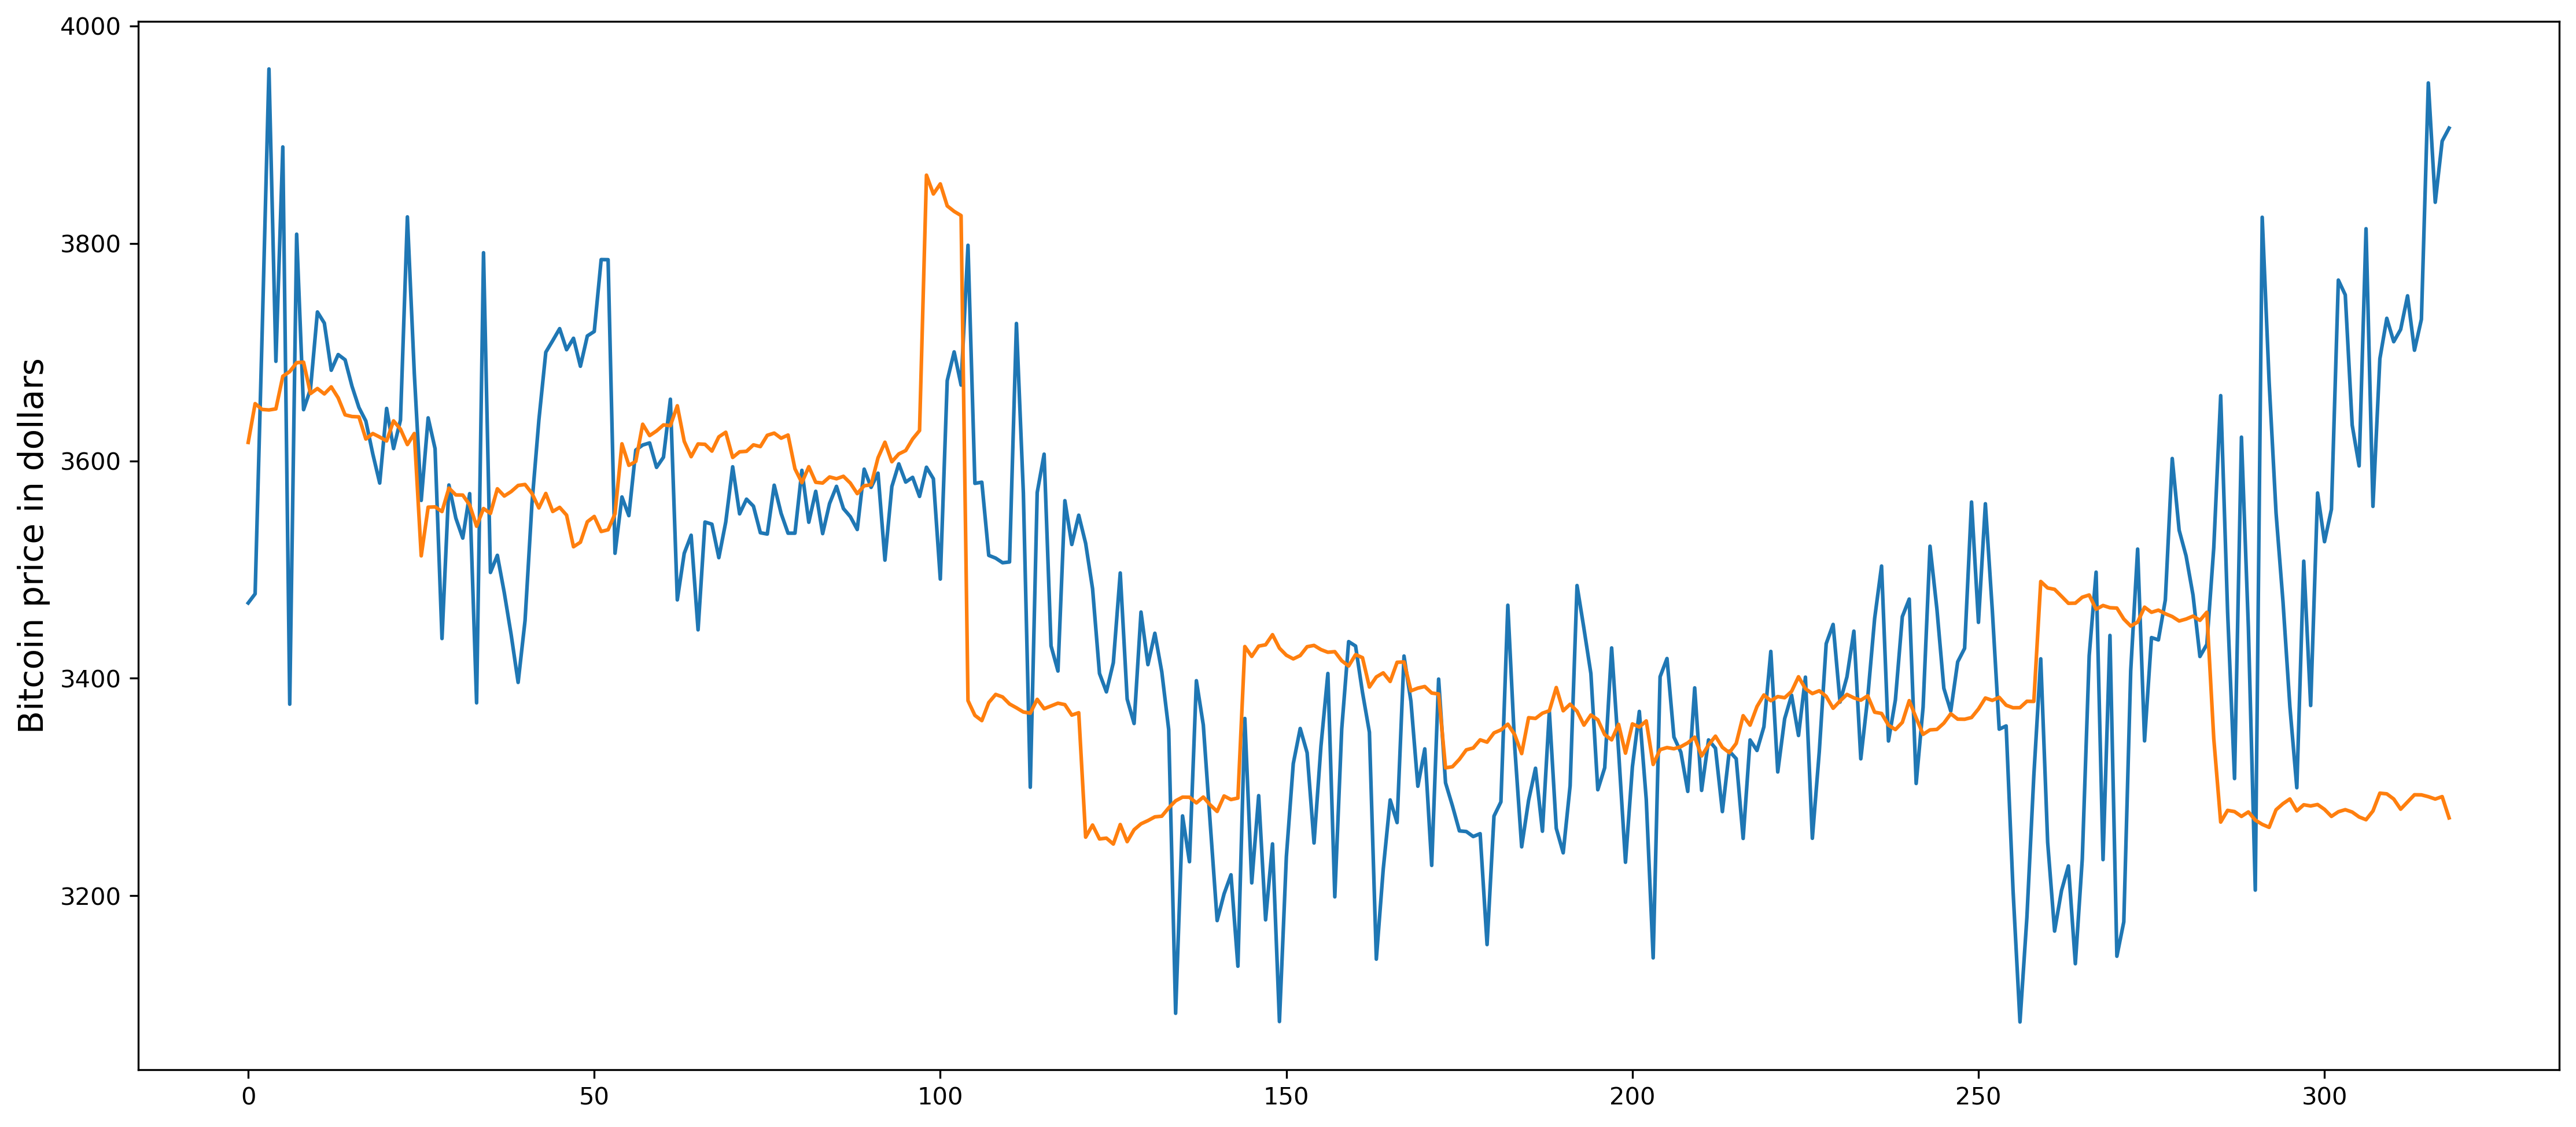

In [75]:
plt.figure(figsize=(18,8))
sns.lineplot(data = predicts_roll_6)
sns.lineplot(data = actuals_roll_6)
plt.ylabel('Bitcoin price in dollars', size = 14)